In [1]:
%load_ext autoreload
%autoreload 2
import apoNN.src.data as apoData
import apoNN.src.utils as apoUtils
import apoNN.src.vectors as vectors
import apoNN.src.fitters as fitters
import apoNN.src.evaluators as evaluators
import apoNN.src.occam as occam_utils

import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
from ppca import PPCA
import inspect

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
import apogee.tools.path as apogee_path
apogee_path.change_dr(16)

In [375]:
n_start = 0
n_stars = 100000 #100000
d = 100 #number of dimensions to use for compression
tol = 0.01 # tolerance to use for PPCA. Larger means faster but less accurate

In [4]:
allStar = apoUtils.load("shuffled_allStar")


In [6]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3.
occamlike_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut
allStar_occamlike =  allStar[np.where(occamlike_cut)]


occam = occam_utils.Occam()
occam_kept = occam.cg_prob>0.8
allStar_occam,cluster_idxs = occam_utils.prepare_occam_allStar(occam_kept,allStar_occamlike)



In [7]:
bad_apogee_id = ['2M02123870+4942289', '2M18051909-3214413', '2M06134865+5518282']
good_ids = [apogee_id not in bad_apogee_id for apogee_id in allStar_occamlike["Apogee_id"]]
allStar_occamlike = allStar_occamlike[good_ids]

In [376]:
data_occamlike = apoData.Dataset(allStar_occamlike[n_start:n_start+n_stars])
data_occam = apoData.Dataset(allStar_occam)


In [377]:
mask_interstellar, interstellar_locs = apoUtils.get_interstellar_bands()

In [378]:
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra[:,mask_interstellar],data_occam.masked_spectra[:,mask_interstellar],d,tol=tol)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))

1.0
0.2600683617049617
0.005872592809863297
0.015222735670891496
0.014700359552744846
0.012744388432561538
0.011216644997566028
0.01009515250424442
0.27188902302070184
0.0016043571626181974


In [379]:
Z_occam = vectors.OccamVector(val = z_occam,cluster_names=cluster_idxs)
Z = vectors.Vector(val = z)

In [844]:
def simple_fitter(z,z_occam):
    """This is a simple fitter that just scales the dimensions of the inputed representation. Which is used as a baseline"""
    return fitters.SimpleFitter(z,z_occam,use_relative_scaling=True,is_pooled=True,is_robust=False)


In [845]:
def standard_fitter(z,z_occam):
    """This fitter performs a change-of-basis to a more appropriate basis for scaling"""
    return fitters.StandardFitter(z,z_occam,use_relative_scaling=True,is_pooled=True,is_robust=False)


In [381]:
n_component = 35
evaluator_X = evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



In [382]:
considered_parameters = ["Fe_H","C_FE","N_FE","O_FE","Na_FE","Mg_FE","Al_FE","Si_FE","S_FE","K_FE","CA_FE","Ni_FE","Cr_FE","Co_FE"] 


In [383]:
Y = vectors.AstroNNVector(allStar_occamlike[n_start:],considered_parameters)


In [384]:
Y_occam = vectors.AstroNNVector(allStar_occam,considered_parameters)
Y_occam = vectors.OccamVector(cluster_names=cluster_idxs, val = Y_occam.val)#.remove_orphans()

In [385]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



0.0205551684963062

In [387]:
Y.val.shape

(159321, 14)

### Filter on SNR

I try and filter on SNR and see how the doppelganger rate is affected

In [21]:
mask_occam_clean =[allStar_occam["SNR"]>200]
mask_occamlike_clean =[allStar_occamlike["SNR"]>200]


#mask_occam_clean = [allStar_occam["VSCATTER"]<1]
#mask_occamlike_clean = [allStar_occamlike["VSCATTER"]<1]

In [22]:
Z_occam_clean = vectors.OccamVector(val = Z_occam[mask_occam_clean].val,cluster_names=Z_occam.cluster_names[mask_occam_clean])
Y_occam_clean = vectors.OccamVector(val = Y_occam[mask_occam_clean].val,cluster_names=Y_occam.cluster_names[mask_occam_clean])

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return OccamVector(self.cluster_names, val = self.val[i])

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

In [23]:
Y_clean =  Y[mask_occamlike_clean]
Z_clean =  Z[mask_occamlike_clean]

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Vector(self.val[i])



IndexError: boolean index did not match indexed array along dimension 0; dimension is 20000 but corresponding boolean dimension is 159321

In [ ]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

In [ ]:
evaluator_Y = evaluators.StandardEvaluator(Y_clean,Y_occam_clean,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

In [ ]:
evaluator_Z = evaluators.StandardEvaluator(Z_clean[:,:n_component],Z_occam_clean[:,:n_component],leave_out=True,fitter_class=standard_fitter)
evaluator_Z.weighted_average

In [ ]:
evaluator_Z = evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter)
evaluator_Z.weighted_average

In [ ]:
n_component = 15

In [ ]:
len(allStar_occam)

In [ ]:
allStar_occamlike["Apogee_id"][7908]

In [ ]:
np.where(np.isnan(Y.val))

In [ ]:
print(inspect.getsource(vectors.OccamVector))

In [ ]:
evaluator_Y_clean = evaluators.StandardEvaluator(Y_clean,Y_occam_clean,leave_out=True,fitter_class=standard_fitter)

In [ ]:
Y_occam_clean.val.shape

In [34]:
Y_occam.val.shape

(200, 14)

### try removing binaries

Tried and didn't change results

### Try comparing similarity from different visits

I think that:
r12-6777-56323-138
corresponds to
?-?-FieldID-fiberID

plate.mjd.fiber

In [93]:
Y_occam.cluster_names

array(['Basel 11b', 'Berkeley 17', 'Berkeley 17', 'Berkeley 17',
       'Berkeley 17', 'Berkeley 17', 'Berkeley 17', 'Berkeley 17',
       'Berkeley 17', 'Berkeley 17', 'Berkeley 19', 'Berkeley 20',
       'Berkeley 20', 'Berkeley 33', 'Berkeley 43', 'Berkeley 53',
       'Berkeley 53', 'Berkeley 53', 'Berkeley 71', 'Berkeley 98',
       'Berkeley 98', 'Berkeley 98', 'Berkeley 98', 'Collinder 220',
       'Czernik 21', 'Czernik 30', 'Czernik 30', 'FSR 0496', 'IC 1369',
       'IC 1369', 'King 7', 'King 7', 'King 7', 'NGC 1193', 'NGC 1193',
       'NGC 1245', 'NGC 1798', 'NGC 1798', 'NGC 1798', 'NGC 1798',
       'NGC 1798', 'NGC 1798', 'NGC 188', 'NGC 188', 'NGC 188', 'NGC 188',
       'NGC 188', 'NGC 188', 'NGC 188', 'NGC 188', 'NGC 188', 'NGC 188',
       'NGC 188', 'NGC 188', 'NGC 188', 'NGC 188', 'NGC 2158', 'NGC 2158',
       'NGC 2158', 'NGC 2158', 'NGC 2158', 'NGC 2158', 'NGC 2158',
       'NGC 2158', 'NGC 2204', 'NGC 2204', 'NGC 2204', 'NGC 2204',
       'NGC 2204', 'NGC 2204',

In [96]:
Y_occam.registry["NGC 2243"]

array([76, 77, 78, 79, 80])

In [24]:
def allStar_to_calendar(allStar):
    """Converts an allstar fits file into an array containing the mjd (observation dates of stars)"""
    mjds = [[visit.split("-")[2] for visit in star.split(",")] for star in allStar["VISITS"]]
    return mjds
    

In [25]:
mjds = allStar_to_calendar(allStar_occam)

In [1208]:
import importlib
importlib.reload(apoData)

<module 'apoNN.src.data' from '/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/data.py'>

In [1209]:
visit_occam = apoData.ApVisitDataset(allStar_occam)
visit_occam.update_masked_spectra(data_occam.errs)

3028 3028
/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/data.py:141: RuntimeWarning: divide by zero encountered in true_divide
  def get_apstar_visit(self,idx,visit_idx):

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/data.py:141: RuntimeWarning: invalid value encountered in true_divide
  def get_apstar_visit(self,idx,visit_idx):

3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
302

3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028
3028 3028


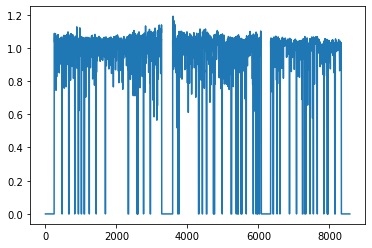

In [1211]:
plt.plot(visit_occam.masked_spectra[0].data[0])
#plt.ylim(0,2)

In [908]:
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra[:,mask_interstellar],data_occam.masked_spectra[:,mask_interstellar],d,tol=tol)


KeyboardInterrupt: 

In [503]:
data_occamlike.masked_spectra.data.shape

(159321, 8575)

### scenario
W : n_features,n_pca_dim

X : n_datapoints,n_features where X contains some missing values

Z = X * W

solution: to only multiply using those features which are in n_features

In [504]:
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra[:,mask_interstellar],data_occam.masked_spectra[:,mask_interstellar],d,tol=tol)


1.0
0.24029146720207661
0.0049586439392503845
0.015281908166963953
0.014643152145559779
0.01266121157710387
0.01111154511154433
0.009988612801074104


In [626]:
x_occam = ppca._standardize(data_occam.masked_spectra[:,mask_interstellar].data)
x_occam = np.nan_to_num(x_occam)
x_occam_mask = data_occam.masked_spectra.mask[:,mask_interstellar]
x_occam_mask = np.isnan(x_occam)+data_occam.masked_spectra.mask[:,mask_interstellar]

In [563]:
np.dot(x_occam[0][~x_occam_mask[0]],ppca.C[~x_occam_mask[0]])

array([ 1.46759257e+01,  2.76598364e+01, -3.19746874e+00,  1.38369092e+01,
        6.71307611e+00,  2.31934867e+00,  1.57630200e+00,  4.29913211e+00,
        3.58420407e+00,  6.26409379e-01,  2.39123525e+00, -3.21316771e+00,
        6.56170044e-01,  2.98570349e+00,  3.28474623e+00, -3.36827606e+00,
       -4.74588062e+00,  3.11710313e+00, -4.24370036e+00, -1.23470004e+00,
       -3.44992883e+00, -1.86570078e-01, -4.61707117e+00,  5.33360056e+00,
       -1.96534333e-01,  1.50007142e+00,  3.47942895e+00, -3.58087912e-01,
       -3.20534110e-01,  9.15228249e-01, -2.54597141e+00,  4.99019777e-01,
        3.57465397e-01, -1.70814321e+00,  1.06216582e+00, -7.84477594e-01,
        6.24954953e-01,  6.40914100e-01,  9.48986765e-02, -4.43256618e+00,
        1.48428877e+00,  2.45206801e-01, -3.44383628e-02,  2.40837933e+00,
       -3.40979336e+00, -1.07866126e+00, -1.20088149e+00,  2.19389922e+00,
       -1.09136472e+00, -9.54372914e-01,  9.90018958e-01, -2.76640107e+00,
        1.64527143e+00,  

In [1212]:
def encode_z(x,x_mask,ppca):
    x = ppca._standardize(x)
    x_mask = x_mask+np.isnan(x)
    x = np.nan_to_num(x)
    return np.array([np.dot(x[i][~x_mask[i]],ppca.C[~x_mask[i]]) for i in range(len(x))])

In [1239]:
z_occam_encoded = encode_z(data_occam.masked_spectra[:,mask_interstellar].data,data_occam.masked_spectra[:,mask_interstellar].mask,ppca)

In [1237]:
z_occamlike_encoded = encode_z(data_occamlike.masked_spectra[:,mask_interstellar].data,data_occamlike.masked_spectra[:,mask_interstellar].mask,ppca)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds



In [1244]:
ev = evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



In [1245]:
ev.weighted_average

0.011129951481600038

In [1246]:
Z2_occam = vectors.OccamVector(val = z_occam_encoded,cluster_names=cluster_idxs)
Z2 = vectors.Vector(val = z_occamlike_encoded)

In [1247]:
ev = evaluators.StandardEvaluator(Z2[:,:n_component],Z2_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter)
ev.weighted_average

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



0.013475530532698139

### Experiment

Finally ready to run experiment

In [1284]:
def get_pairs(mjds,Z_occam):
    """Return a triplet of star_index,visit_index with the first entry containing a random star and random visit.
    The second entry a matching visit from a star in the cluster
    The third entry a non-matching visit from a star in the cluster"""
    star_idx = random.randint(0,len(Z_occam.cluster_names)-1)
    cluster = Z_occam.cluster_names[star_idx]
    cluster_idxs = [i for i in Z_occam.registry[cluster] if i!=star_idx] #remove the chosen star
    mjd = random.choice(mjds[star_idx])
    mjd_idx = mjds[star_idx].index(mjd)
    #print(f"star_idx:{star_idx}")
    #print(f"mjd:{mjd}")

    pair_idx = np.random.choice(cluster_idxs)
    #print(f"pair_idx:{pair_idx}")

    mjd_pair_idx = mjds[pair_idx].index(mjd)
    mjd_idxs = [i for i in mjds[star_idx] if i!=mjd] #remove the chosen visit from potential samples
    random_mjd = random.choice(mjd_idxs)
    mjd_random_idx = mjds[pair_idx].index(random_mjd)
    return [star_idx,mjd_idx],[pair_idx,mjd_pair_idx],[pair_idx,mjd_random_idx]

In [1285]:
def make_pairs(mjds,Z_occam,n_pairs):
    added_pairs = 0
    star_pairs = []
    match_pairs = []
    random_pairs = []
    while added_pairs<n_pairs:
        try:
            star_pair,match_pair,random_pair = get_pairs(mjds,Z_occam)
            star_pairs.append(star_pair)
            match_pairs.append(match_pair)
            random_pairs.append(random_pair)
            added_pairs+=1
        except:
            pass
        
    return star_pairs,match_pairs,random_pairs

In [1286]:
star_pairs,match_pairs,random_pairs = make_pairs(mjds,Z_occam,10000)

In [1287]:
star_xs = np.ma.array([visit_occam.masked_spectra[pair[0]][pair[1]] for pair in star_pairs])
match_xs = np.ma.array([visit_occam.masked_spectra[pair[0]][pair[1]] for pair in match_pairs])
random_xs = np.ma.array([visit_occam.masked_spectra[pair[0]][pair[1]] for pair in random_pairs])


In [1409]:
mjds[1:15]

[['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['56284', '56290', '56585'],
 ['57683', '57684', '57708'],
 ['57707'],
 ['56267', '56288', '56592'],
 ['56465', '56472', '56537', '56539']]

(4600, 5000)

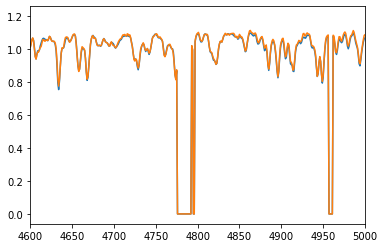

In [1450]:
idx = 3
plt.plot(data_occam.masked_spectra[idx].data)
plt.plot(visit_occam.masked_spectra[idx][1].data)
plt.xlim(4600,5000)

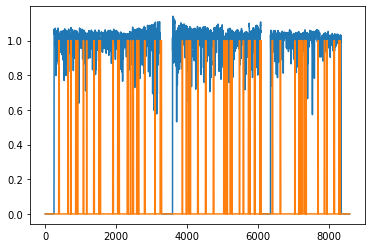

In [1338]:
plt.plot(star_xs[0])
plt.plot(star_xs[0].mask)

In [1288]:
Z_star = vectors.Vector(encode_z(star_xs[:,mask_interstellar].data,star_xs[:,mask_interstellar].mask,ppca))
Z_match = vectors.Vector(encode_z(match_xs[:,mask_interstellar].data,match_xs[:,mask_interstellar].mask,ppca))
Z_random = vectors.Vector(encode_z(random_xs[:,mask_interstellar].data,random_xs[:,mask_interstellar].mask,ppca))

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds



In [1289]:
z_dim = 30
Z_fitter = standard_fitter(Z[:,:z_dim],Z_occam[:,:z_dim])
v_star = Z_fitter.transform(Z_star[:,:z_dim].centered(Z_occam[:,:z_dim])).val
v_match = Z_fitter.transform(Z_match[:,:z_dim].centered(Z_occam[:,:z_dim])).val
v_random = Z_fitter.transform(Z_random[:,:z_dim].centered(Z_occam[:,:z_dim])).val


/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

(array([ 1.,  0.,  4., 13., 33., 36.,  9.,  3.,  0.,  1.]),
 array([-12.33479695,  -9.82657036,  -7.31834378,  -4.8101172 ,
         -2.30189061,   0.20633597,   2.71456256,   5.22278914,
          7.73101572,  10.23924231,  12.74746889]),
 <a list of 10 Patch objects>)

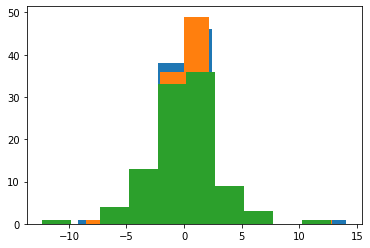

In [1290]:
plt.hist(z_occam[1])
plt.hist(z_encoded[1])
plt.hist(z_random[1])

In [1291]:
random_idxs = list(range(len(v_star)))
random.shuffle(random_idxs)
random_idxs

[2311,
 1405,
 1148,
 3430,
 429,
 8636,
 647,
 8740,
 8823,
 6556,
 9561,
 9889,
 5899,
 4193,
 7654,
 6670,
 2623,
 1821,
 4786,
 7271,
 8656,
 3619,
 724,
 673,
 5562,
 2024,
 520,
 7475,
 604,
 3540,
 3362,
 6835,
 3009,
 2709,
 1610,
 3506,
 9944,
 8081,
 1032,
 2757,
 6651,
 2162,
 5240,
 1837,
 430,
 9802,
 6324,
 7039,
 6520,
 504,
 492,
 3168,
 7280,
 9314,
 1013,
 8934,
 2871,
 3802,
 7107,
 5849,
 4043,
 7390,
 5021,
 8312,
 7257,
 7796,
 4533,
 3371,
 4200,
 4982,
 7449,
 868,
 6267,
 4195,
 9971,
 685,
 5567,
 6126,
 3642,
 2624,
 6040,
 4063,
 2863,
 2715,
 7713,
 4391,
 351,
 5614,
 3123,
 8744,
 5564,
 9493,
 910,
 4565,
 9076,
 7030,
 3609,
 3827,
 819,
 9823,
 5271,
 1279,
 8390,
 5597,
 6219,
 5789,
 2535,
 8899,
 1514,
 6881,
 3193,
 5216,
 3646,
 9846,
 5815,
 3726,
 361,
 8105,
 5605,
 6688,
 2697,
 2105,
 7141,
 2239,
 461,
 1526,
 2980,
 7229,
 6553,
 2840,
 3571,
 8364,
 2920,
 2685,
 2437,
 5801,
 4911,
 9606,
 466,
 9025,
 4552,
 2086,
 5747,
 7521,
 7151,
 4

In [1294]:
np.mean(np.linalg.norm(v_star-v_match,axis=1))

17.994457995896173

(0, 500)

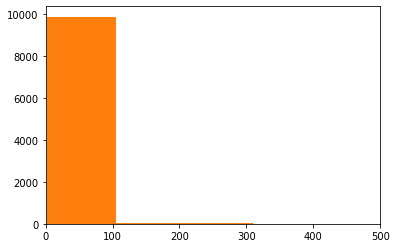

In [1155]:
plt.hist(np.linalg.norm(v_star-v_match,axis=1))
plt.hist(np.linalg.norm(v_star-v_random,axis=1))
plt.xlim(0,500)

In [1295]:
np.linalg.norm(v_star-v_match,axis=1)[0:20]

array([ 2.1899375 , 14.79011018,  4.56403609, 13.48972087, 29.31900203,
       24.61830332,  9.80514822,  6.21548191, 19.32168067,  9.67804872,
       11.84690765,  8.85805328,  6.55090308, 23.19471094,  7.44029689,
        9.27964348,  7.78976552,  9.95873033,  3.67014293, 11.63873738])

In [1296]:
np.linalg.norm(v_star-v_random,axis=1)[0:20]

array([ 3.16969076, 12.38676739,  5.40727969, 17.87513514, 27.60592139,
       24.10210711, 39.11618305, 24.42447901, 15.83243384,  8.81603568,
       27.69396737,  8.55116865, 10.24583989, 25.37788547,  8.00059164,
        9.90501711,  9.75516082,  8.00059164,  3.52893461,  5.60265282])

In [1326]:
val_idxs = (np.linalg.norm(v_star-v_random,axis=1)<50) & (np.linalg.norm(v_star-v_match,axis=1)<50)

In [1327]:
np.mean(np.linalg.norm(v_star-v_random,axis=1))

21.82295154113415

In [1328]:
np.mean(np.linalg.norm(v_star-v_match,axis=1))

17.994457995896173

In [1329]:
np.mean(np.linalg.norm(v_star-v_match[random_idxs],axis=1))

31.763088523601425

In [1330]:
np.mean(np.linalg.norm(v_star-v_random[random_idxs],axis=1))

32.27340585518551

### To Do

- Use targetted errors per visit instead of general error.
- Get encoding to match perfectly.
- Experiment with seeing how well encoding works on visits

find which regions of spectra have big differences between visits.

Methodology: Calculate mean per-pixel difference between visits of the same star

Pairs: Find stars in clusters with doublets of shared observation. Then swap them.

Encoding: Replace masked values with expected values rather than setting them to 0.

In [1452]:
ppca.means

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [1454]:
ppca.means.shape

(7835,)

In [1472]:
def encode_z(x,x_mask,ppca):
    x = ppca._standardize(x)
    x_mask = x_mask+np.isnan(x)
    x = np.nan_to_num(x)
    return np.array([np.dot(x[i][~x_mask[i]],ppca.C[~x_mask[i]]) for i in range(len(x))])

In [1474]:
def encode_z2(x,x_mask,ppca):
    x = ppca._standardize(x)
    x_mask = x_mask+np.isnan(x)
    x = np.nan_to_num(x)
    expected_values = ppca.means[None,:].repeat(len(x),axis=0)
    x[np.where(x_mask)] = expected_values[np.where(x_mask)]
    return np.dot(x,ppca.C)

In [1459]:
expected_occam = ppca.means[None,:].repeat(len(x_occam),axis=0)

In [1482]:
z_occam_encoded = encode_z(data_occam.masked_spectra[:,mask_interstellar].data,data_occam.masked_spectra[:,mask_interstellar].mask,ppca)

In [1483]:
z_occam_encoded

array([[ 14.67592572,  27.6598364 ,  -3.19746874, ...,  -1.32845114,
         -1.01143302,  -0.76285722],
       [ -2.37633161,  12.87846829,  -8.52601296, ...,  -0.99494767,
         -0.56360385,   0.08423751],
       [ -8.84352258,  15.90249043,  -2.91773199, ...,  -0.64132547,
          0.35253706,   0.10579765],
       ...,
       [-44.95405148,   3.62896551,   8.83264611, ...,  -2.26043804,
          0.32137567,   0.05835109],
       [-49.85325113,   4.04742041,   7.97228106, ...,  -1.00778128,
          1.05162893,  -0.93241252],
       [-42.64796929,   1.63057033,   6.42010326, ...,  -0.58350094,
          1.31169941,  -0.61165521]])

In [1484]:
z_occam_encoded2 = encode_z2(data_occam.masked_spectra[:,mask_interstellar].data,data_occam.masked_spectra[:,mask_interstellar].mask,ppca)

In [1485]:
z_occam_encoded2

array([[ 15.09856797,  28.04597847,  -3.34187669, ...,  -1.01055362,
         -0.43602388,  -1.17516496],
       [ -0.73833974,  12.42716278, -10.22059107, ...,  -1.42231078,
          0.20908279,   0.3487465 ],
       [ -7.20575254,  16.12893642,  -4.7271128 , ...,  -1.04830051,
          0.78218958,   1.20425216],
       ...,
       [-43.66642695,   1.3246753 ,   7.87456932, ...,  -4.86201722,
          1.67033576,  -0.33244167],
       [-48.61116211,   2.20612269,   7.11371841, ...,  -4.08749303,
          2.65397449,  -0.98752328],
       [-40.75561532,   2.1142466 ,   5.9435164 , ...,  -2.34604736,
          2.35474689,  -1.21823219]])

In [1499]:
visit_occam.spectra

array([list([array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]),
       list([array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]),
       list([array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]),
       list([array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]),
       list([array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)]),
       list([array([nan, nan, nan, ..., 

In [1515]:
res=0
for spectra in visit_occam.masked_spectra:
    print("here")
    res+=np.mean(spectra.data-np.mean(spectra.data,axis=0),axis=0)

In [1525]:
np.array(mjds)[Y_occam.registry["NGC 6819"]]

array([list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']),
       list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']),
       list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']), list(['56460', '56462']),
       list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']), list(['56460', '56462']),
       list(['56741', '56745', '56746']), list(['56460', '56462']),
       list(['58282', '58283', '58284']),
       list(['55823', '55840', '55851']), list(['56460', '56462']),
       list(['55813', '55849', '55866']),
       list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']),
       list(['55823', '55840', '55851']),
       list(['56741', '56745', '56746']),
       list(['55823', '55840', '55851']),
       list(['56741', '56745', '56746']),
       list(['55823', '55840', '55851']),
       list(['55813', '55849', '55866']),
       list(['55823', '55840', '55851']),
       list(['

In [1529]:
for cluster in Y_occam.registry:
    print(cluster)
    print(np.array(mjds)[Y_occam.registry[cluster]])

Czernik 30
[list(['56372', '56643', '56653', '56654'])
 list(['56372', '56643', '56653', '56654'])]
NGC 6819
[list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['56460', '56462']) list(['55823', '55840', '55851'])
 list(['55813', '55849', '55866']) list(['56460', '56462'])
 list(['56741', '56745', '56746']) list(['56460', '56462'])
 list(['58282', '58283', '58284']) list(['55823', '55840', '55851'])
 list(['56460', '56462']) list(['55813', '55849', '55866'])
 list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['55823', '55840', '55851']) list(['56741', '56745', '56746'])
 list(['55823', '55840', '55851']) list(['56741', '56745', '56746'])
 list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['55823', '55840', '55851']) list(['55813', '55849', '55866'])
 list(['55813', '55849', '5586

In [1526]:
Y_occam.registry

{'Czernik 30': array([25, 26]),
 'NGC 6819': array([146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174]),
 'NGC 2324': array([83]),
 'Czernik 21': array([24]),
 'Ruprecht 147': array([190]),
 'Berkeley 98': array([19, 20, 21, 22]),
 'NGC 6705': array([104, 105]),
 'NGC 4337': array([102, 103]),
 'Berkeley 43': array([14]),
 'NGC 1193': array([33, 34]),
 'NGC 6791': array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]),
 'NGC 7789': array([176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189]),
 'FSR 0496': array([27]),
 'NGC 1798': array([36, 37, 38, 39, 40, 41]),
 'NGC 2243': array([76, 77, 78, 79, 80]),
 'Berkeley 19': array([10]),
 'Berkeley 20': array([11, 12]),
 'Berkeley 33': array([13])

### Similarity as a function of overlap

In [612]:
def get_overlap(mjds,idx1,idx2):
    mjd1 = mjds[idx1]
    mjd2 = mjds[idx2]
    num_overlap = len(set(mjd1).intersection(mjd2))
    return 0.5*(num_overlap/len(mjd1)+num_overlap/len(mjd2))


def allStar_to_calendar(allStar):
    """Converts an allstar fits file into an array containing the mjd (observation dates of stars)"""
    mjds = [[visit.split("-")[2] for visit in star.split(",")] for star in allStar["VISITS"]]
    return mjds
    

In [772]:
# calculate similarity between pairs of stars as a function of the overlap in visits

def get_mjd_overlap(idx1,idx2):
    mjd1 = mjds[idx1]
    mjd2 = mjds[idx2]
    num_overlap = len(set(mjd1).intersection(mjd2))
    return 0.5*(num_overlap/len(mjd1)+num_overlap/len(mjd2))


"""
def get_mjd_overlap(mjds,idx1,idx2):
    #mostly for debugging
    mjd1 = Y_occam.val[:,0][idx1]#allStar_occam["FE_H"][idx1]
    mjd2 = Y_occam.val[:,0][idx2]#allStar_occam["FE_H"][idx2]
    return np.abs(mjd1-mjd2)
"""

def similarity_ij(i,j,v):
    return np.linalg.norm(v[i]-v[j])


def get_SNRs(idx1,idx2):
    return np.min([allStar_occam["SNR"][idx1],allStar_occam["SNR"][idx2]])

def jitter(arr,jit_strength=0.01):
    return arr+jit_strength*np.random.randn(*arr.shape)

In [761]:
def make_intracluster_similarity_trends(V_occam,get_y):
    """Measures the similarities for all stellar sibling pairs in the dataset and for a y-parameter.
    Parameters
    ----------
    V_occam: Vectors.OccamVector
        OccamVector containing the final transformed representation on which metric learning is applied.
    get_y: function
        Function which takes idx1,idx2 - the indexes of a pair of stars -  and returns the y quantity of interest
    Outputs
    -------
    all_similarities: np.array
        Contains the similarities for all stars in the dataset
    all_y: np.array
        Contains the associated y values for every pair in all_similarities
    """
    all_similarities = []
    all_ys = []
    for cluster in V_occam.registry:
    #for cluster in ['NGC 7789']:
        clust_size = len(V_occam.registry[cluster])
        if clust_size>1:
            combinations = evaluators.BaseEvaluator.get_combinations(clust_size)
            pairings = np.array(V_occam.registry[cluster][np.array(combinations)])
            v1 = V_occam.val[pairings[:,0]]
            v2 = V_occam.val[pairings[:,1]]
            similarities = np.linalg.norm(v1-v2,axis=1)
            ys = np.array([get_y(pair[0],pair[1]) for pair in pairings])
            #overlaps = np.array([get_mjd_overlap(mjds,pair[1],pair[0]) for pair in pairings])
            #overlaps = np.array([np.min([allStar_occam["SNR"][pair[0]],allStar_occam["SNR"][pair[1]]]) for pair in pairings])
            #overlaps = np.array([allStar_occam["VHELIO_AVG"][pair[0]]-allStar_occam["VHELIO_AVG"][pair[1]] for pair in pairings])
            all_similarities.append(similarities)
            all_ys.append(ys)
            
    return  np.concatenate(all_similarities), np.concatenate(all_ys)

In [828]:
Z_fitter = standard_fitter(Z[:,:z_dim],Z_occam[:,:z_dim])
V_occam = Z_fitter.transform(Z_occam[:,:z_dim].centered(Z_occam[:,:z_dim]))

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")



In [822]:
Y_fitter = simple_fitter(Y,Y_occam)
#Y_fitter = standard_fitter(Y,Y_occam)
V_occam = Y_fitter.transform(Y_occam.centered(Y_occam))

In [829]:
similarities, overlaps = make_intracluster_similarity_trends(V_occam,get_mjd_overlap)

In [807]:
similarities, SNRs = make_intracluster_similarity_trends(V_occam,get_SNRs)

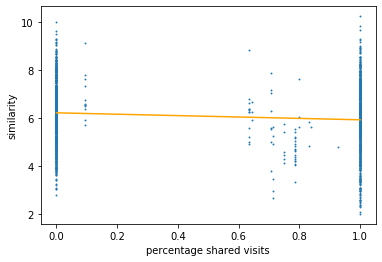

In [768]:
plt.scatter(overlaps,similarities,s=0.8)
plt.xlabel("percentage shared visits")
plt.ylabel("similarity")
plt.plot(overlaps,np.poly1d(np.polyfit(overlaps, similarities, 1))(overlaps),color="orange",label="from spectra")

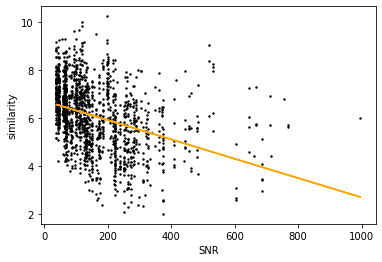

In [857]:
plt.scatter(SNRs,similarities,s=2.0,color="black")
plt.xlabel("SNR")
plt.ylabel("similarity")
plt.plot(SNRs,np.poly1d(np.polyfit(SNRs, similarities, 1))(SNRs),color="orange",label="from spectra")

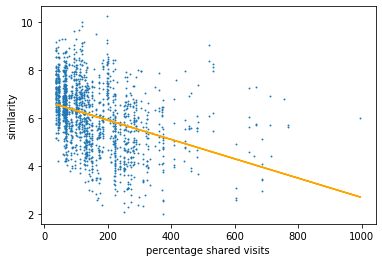

In [850]:
plt.scatter(SNRs,similarities,s=0.8)
plt.xlabel("percentage shared visits")
plt.ylabel("similarity")
plt.plot(SNRs,np.poly1d(np.polyfit(SNRs, similarities, 1))(SNRs),color="orange",label="from spectra")

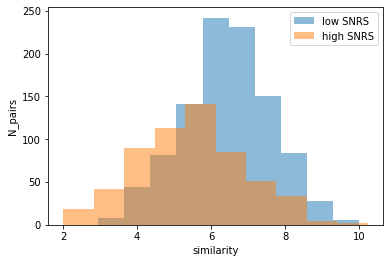

In [849]:
plt.hist(similarities[(SNRs<150)],alpha=0.5,label = "low SNRS",density=False)
plt.hist(similarities[SNRs>150],alpha=0.5,label= "high SNRS",density=False)
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

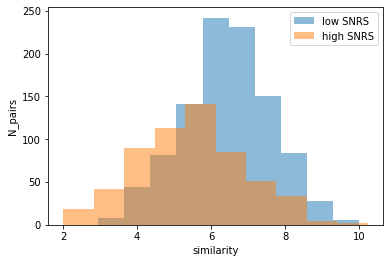

In [848]:
plt.hist(similarities[(SNRs<150)],alpha=0.5,label = "low SNRS",density=False)
plt.hist(similarities[SNRs>150],alpha=0.5,label= "high SNRS",density=False)
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

In [833]:
np.mean(similarities[(SNRs<150)])

6.440717749266153

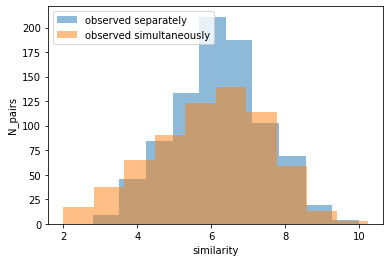

In [830]:
plt.hist(similarities[overlaps==0],alpha=0.5,label = "observed separately")
plt.hist(similarities[overlaps==1],alpha=0.5,label= "observed simultaneously")
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

In [831]:
np.mean(similarities[overlaps==0])

6.213068784768634

In [832]:
np.mean(similarities[overlaps==1])

5.968844292232241

In [782]:
all_similarities = []
all_overlaps = []
for cluster in Z_occam.registry:
#for cluster in ['NGC 7789']:
    clust_size = len(Z_occam.registry[cluster])
    if clust_size>1:
        combinations = evaluators.BaseEvaluator.get_combinations(clust_size)
        pairings = np.array(Z_occam.registry[cluster][np.array(combinations)])
        v1 = V_occam.val[pairings[:,0]]
        v2 = V_occam.val[pairings[:,1]]
        similarities = np.linalg.norm(v1-v2,axis=1)
        overlaps = np.array([get_mjd_overlap(mjds,pair[1],pair[0]) for pair in pairings])
        #overlaps = np.array([np.min([allStar_occam["SNR"][pair[0]],allStar_occam["SNR"][pair[1]]]) for pair in pairings])
        #overlaps = np.array([allStar_occam["VHELIO_AVG"][pair[0]]-allStar_occam["VHELIO_AVG"][pair[1]] for pair in pairings])
        all_similarities.append(similarities)
        all_overlaps.append(overlaps)

TypeError: get_mjd_overlap() takes 2 positional arguments but 3 were given

In [758]:
all_similarities = np.concatenate(all_similarities)
all_overlaps = np.concatenate(all_overlaps)

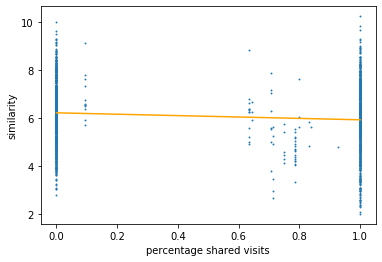

In [759]:
plt.scatter(all_overlaps,all_similarities,s=0.8)
plt.xlabel("percentage shared visits")
plt.ylabel("similarity")
plt.plot(all_overlaps,np.poly1d(np.polyfit(all_overlaps, all_similarities, 1))(all_overlaps),color="orange",label="from spectra")

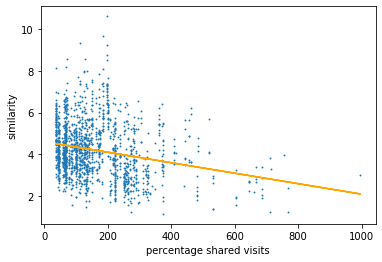

In [666]:
plt.scatter(jitter(all_overlaps),all_similarities,s=0.8)
plt.xlabel("percentage shared visits")
plt.ylabel("similarity")
plt.plot(all_overlaps,np.poly1d(np.polyfit(all_overlaps, all_similarities, 1))(all_overlaps),color="orange",label="from spectra")

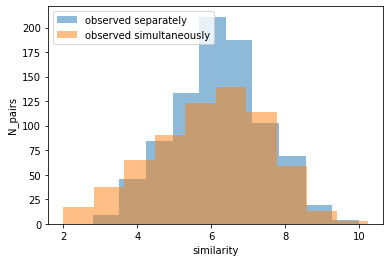

In [710]:
plt.hist(all_similarities[all_overlaps==0],alpha=0.5,label = "observed separately")
plt.hist(all_similarities[all_overlaps==1],alpha=0.5,label= "observed simultaneously")
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

(array([ 20.,  69., 147., 183., 112.,  69.,  40.,  15.,   2.,   3.]),
 array([ 1.19085896,  2.09201773,  2.99317649,  3.89433526,  4.79549402,
         5.69665279,  6.59781155,  7.49897032,  8.40012909,  9.30128785,
        10.20244662]),
 <a list of 10 Patch objects>)

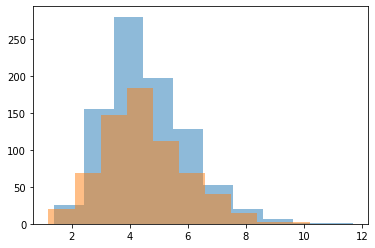

In [501]:
plt.hist(all_similarities[all_overlaps==0],alpha=0.5)
plt.hist(all_similarities[all_overlaps==1],alpha=0.5)

In [492]:
np.mean(all_similarities[all_overlaps==0])

7.186337073173827

In [493]:
np.mean(all_similarities[all_overlaps==1])

6.859164468776451

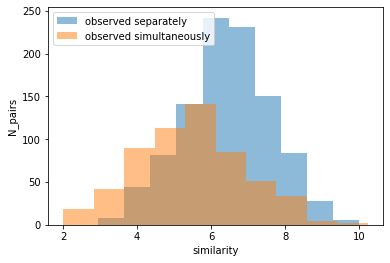

In [716]:
plt.hist(all_similarities[(all_overlaps<150)],alpha=0.5,label = "observed separately",density=False)
plt.hist(all_similarities[all_overlaps>150],alpha=0.5,label= "observed simultaneously",density=False)
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

In [838]:
plt.hist(all_similarities[(all_overlaps<150)],alpha=0.5,label = "observed separately",density=False)
plt.hist(all_similarities[all_overlaps>150],alpha=0.5,label= "observed simultaneously",density=False)
plt.xlabel("similarity")
plt.ylabel("N_pairs")
plt.legend()

TypeError: '<' not supported between instances of 'list' and 'int'

In [842]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



0.0205551684963062

In [843]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=simple_fitter)
evaluator_Y.weighted_average

0.020494661720677123

In [846]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/evaluators.py:85: RuntimeWarning: invalid value encountered in less
  doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))



0.020408891483231967

In [847]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=simple_fitter)
evaluator_Y.weighted_average

0.02228899517326655